In [1]:
%load_ext autoreload
%autoreload 2

from pdac_utils import *
from IPython.display import Image
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
from glob import glob
from matplotlib import pyplot as plt
import os
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)

/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
genemarkers = load_genemarkers()
pid_versions = get_pid_version_map()
broad_celltypes = get_broad_celltypes()

In [3]:
combinetreateddata = sc.read("data/combinetreateddata-reprocessed-clean.h5ad")

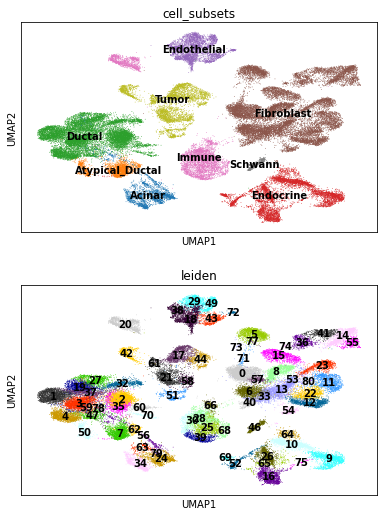

In [4]:
sc.pl.umap(combinetreateddata, color=['cell_subsets', 'leiden'], ncols=1, legend_loc='on data')

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:01:37)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:21)
running Leiden clustering
    finished: found 52 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)


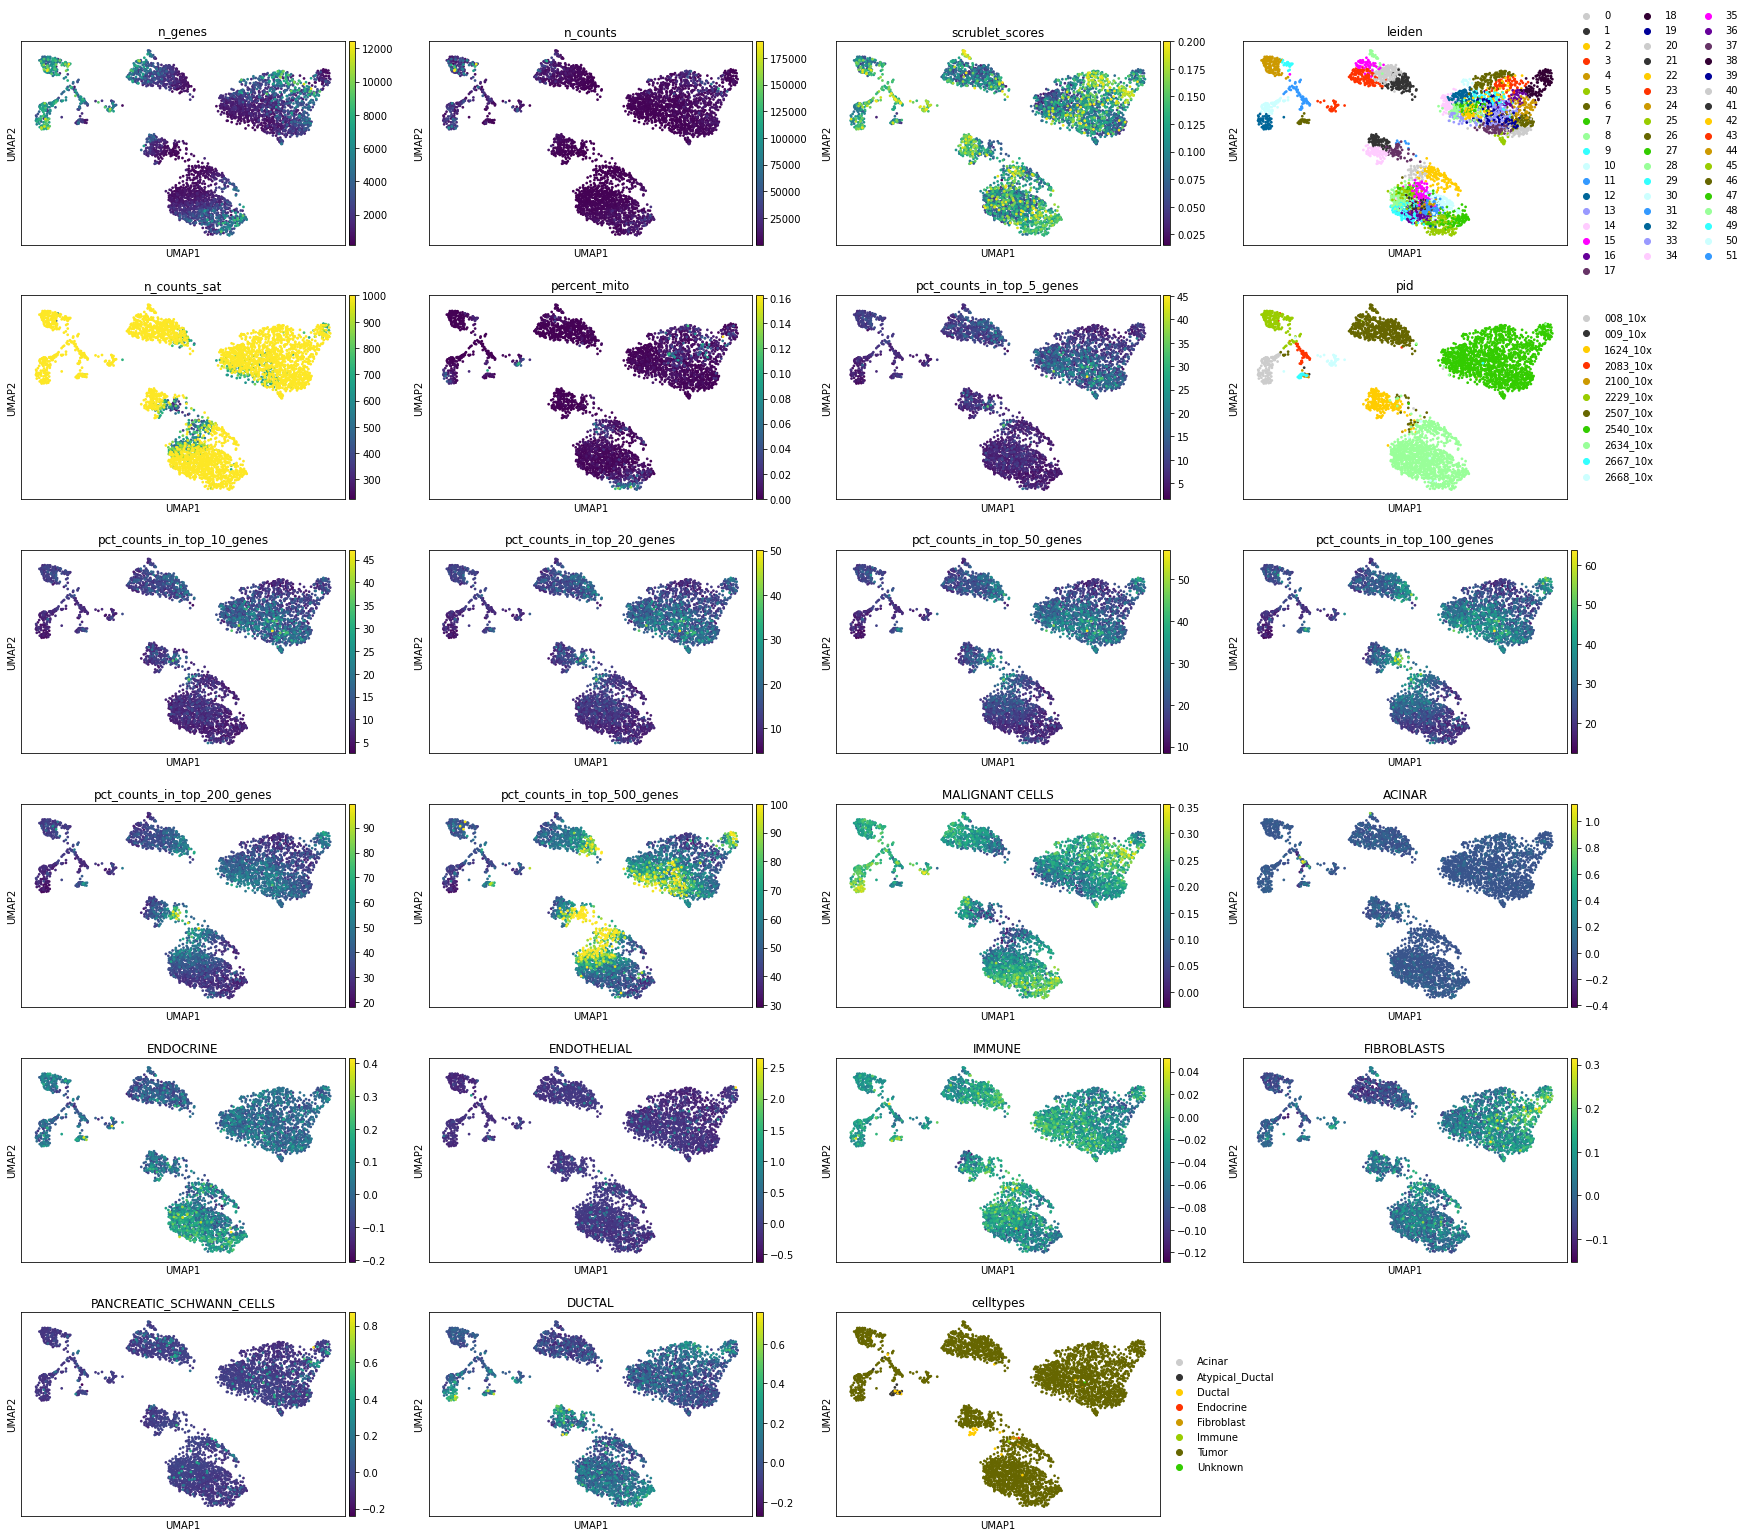

In [5]:
subsetdata = combinetreateddata[combinetreateddata.obs['cell_subsets']=='Tumor']
subsetdata = recompute_umap(subsetdata)
#subsetdata.write('/ahg/regevdata/projects/Pancreas/src/treatedtumor_nmf.h5ad')

In [7]:
subsetdata.write('/ahg/regevdata/projects/Pancreas/src/treatedtumor_nmf.h5ad')

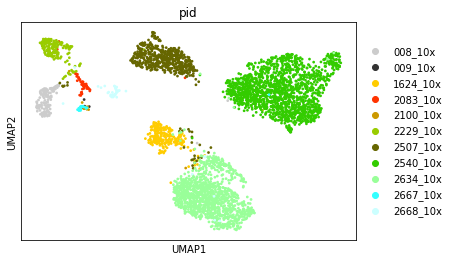

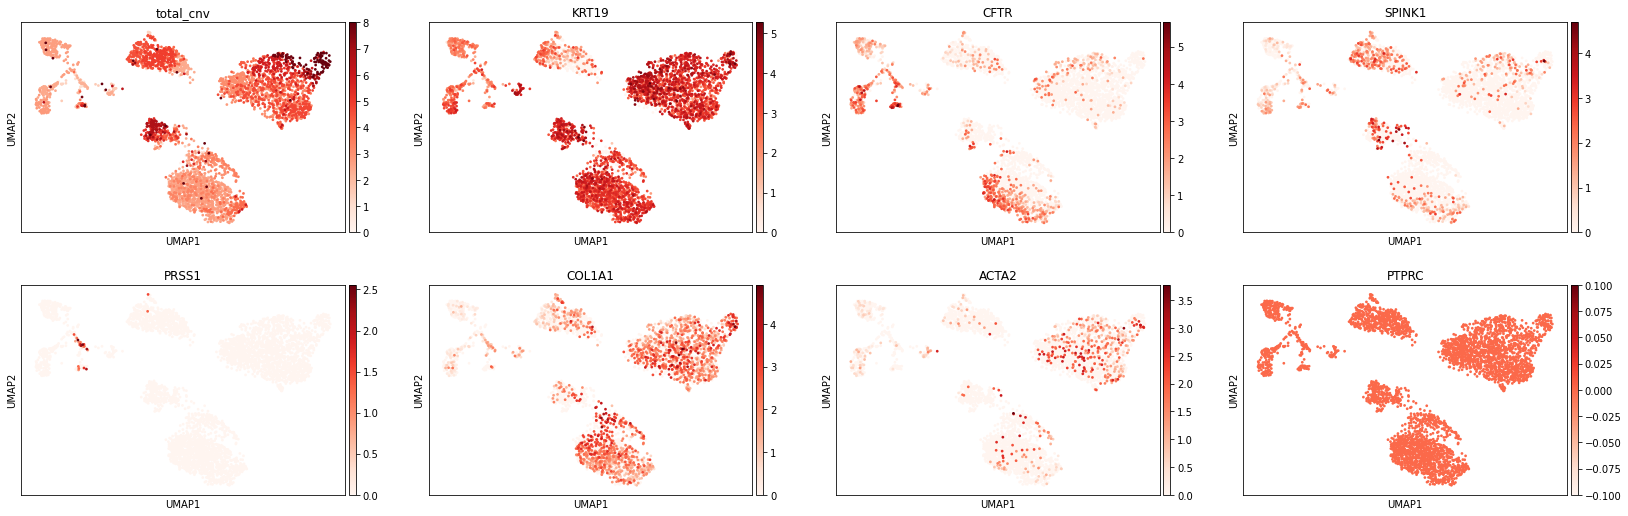

In [6]:
sc.pl.umap(subsetdata, color='pid')
sc.pl.umap(subsetdata, color=['total_cnv', 'KRT19', 'CFTR', 'SPINK1', 'PRSS1', 'COL1A1', 'ACTA2', 'PTPRC'], color_map='Reds')

In [3]:
subsetdata = sc.read('/ahg/regevdata/projects/Pancreas/src/treatedtumor_nmf.h5ad')

In [4]:
! lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                16
On-line CPU(s) list:   0-15
Thread(s) per core:    1
Core(s) per socket:    8
Socket(s):             2
NUMA node(s):          1
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 45
Model name:            Intel(R) Xeon(R) CPU E5-2680 0 @ 2.70GHz
Stepping:              7
CPU MHz:               2699.835
CPU max MHz:           2700.0000
CPU min MHz:           1200.0000
BogoMIPS:              5399.93
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              20480K
NUMA node0 CPU(s):     0-15
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc aperfmperf eagerfpu pni p

In [7]:
numiter=50 # Number of NMF replicates. Set this to a larger value ~200 for real data. We set this to a relatively low value here for illustration at a faster speed
numworkers=100
numhvgenes=subsetdata.shape[1] ## Number of over-dispersed genes to use for running the actual factorizations

basedir = '/ahg/regevdata/projects/Pancreas/src'

## Results will be saved to [output_directory]/[run_name] which in this example is example_PBMC/cNMF/pbmc_cNMF
output_directory = basedir + '/cNMF/treated_tumor_cNMF'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
run_name = 'pbmc_cNMF2'

## To speed this up, you can run it for only K=7-8 with the option below
K = ' '.join([str(i) for i in range(16,22)])


seed = 14 ## Specify a seed pseudorandom number generation for reproducibility

## Path to the filtered counts dataset we output previously
countfn = '/ahg/regevdata/projects/Pancreas/src/treatedtumor_nmf.h5ad'

In [6]:
prepare_cmd = '/home/unix/kjag/.conda/envs/pegasus/bin/python cnmf.py prepare --output-dir %s --name %s -c %s -k %s --n-iter %d --total-workers %d --seed %d --numgenes %d --beta-loss frobenius' % (output_directory, run_name, countfn, K, numiter, numworkers, seed, numhvgenes)
print('Prepare command assuming parallelization with %d cores:\n%s' % (numworkers, prepare_cmd))
! {prepare_cmd}

Prepare command assuming parallelization with 100 cores:
/home/unix/kjag/.conda/envs/pegasus/bin/python cnmf.py prepare --output-dir /ahg/regevdata/projects/Pancreas/src/cNMF/treated_tumor_cNMF --name pbmc_cNMF3 -c /ahg/regevdata/projects/Pancreas/src/treatedtumor_nmf.h5ad -k 16 17 18 19 20 21 --n-iter 50 --total-workers 100 --seed 14 --numgenes 22164 --beta-loss frobenius
/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
(4015, 22164)
/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:909: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:1225: RuntimeWarning: divide by zero encount

In [7]:
"""## Submitting all of the factorization jobs for the 0th (I.e. the only) worker
factorize_cmd = '/home/unix/kjag/.conda/envs/pegasus/bin/python cnmf.py factorize --output-dir %s --name %s --worker-index 0' % (output_directory, run_name)
print('Factorize command with no parallelization:\n%s' % factorize_cmd)
!{factorize_cmd}
"""
## Using GNU parallel
## This took 4 minutes in our testing
worker_index = ' '.join([str(x) for x in range(numworkers)])
factorize_cmd = '/home/unix/kjag/.conda/envs/pegasus/bin/python %s/cnmf.py factorize --output-dir %s --name %s --worker-index %s --total-workers %d'
commands = []
for i in worker_index.split(' '):
    commands.append(factorize_cmd%(basedir, output_directory, run_name, i, numworkers))
commands = "\n".join(commands)
print('Factorize command to simultaneously run factorization over %d cores using GNU parallel:\n%s' % (numworkers, commands))

joblist = open("/ahg/regevdata/projects/Pancreas/src/cNMF/treated_tumor_cNMF/joblist2", "w")
joblist.write(commands)
joblist.close()
#!{commands}

Factorize command to simultaneously run factorization over 100 cores using GNU parallel:
/home/unix/kjag/.conda/envs/pegasus/bin/python /ahg/regevdata/projects/Pancreas/src/cnmf.py factorize --output-dir /ahg/regevdata/projects/Pancreas/src/cNMF/treated_tumor_cNMF --name pbmc_cNMF3 --worker-index 0 --total-workers 100
/home/unix/kjag/.conda/envs/pegasus/bin/python /ahg/regevdata/projects/Pancreas/src/cnmf.py factorize --output-dir /ahg/regevdata/projects/Pancreas/src/cNMF/treated_tumor_cNMF --name pbmc_cNMF3 --worker-index 1 --total-workers 100
/home/unix/kjag/.conda/envs/pegasus/bin/python /ahg/regevdata/projects/Pancreas/src/cnmf.py factorize --output-dir /ahg/regevdata/projects/Pancreas/src/cNMF/treated_tumor_cNMF --name pbmc_cNMF3 --worker-index 2 --total-workers 100
/home/unix/kjag/.conda/envs/pegasus/bin/python /ahg/regevdata/projects/Pancreas/src/cnmf.py factorize --output-dir /ahg/regevdata/projects/Pancreas/src/cNMF/treated_tumor_cNMF --name pbmc_cNMF3 --worker-index 3 --total

In [6]:
cmd = '/home/unix/kjag/.conda/envs/pegasus/bin/python cnmf.py combine --output-dir %s --name %s' % (output_directory, run_name)
print(cmd)
!{cmd}

/home/unix/kjag/.conda/envs/pegasus/bin/python cnmf.py combine --output-dir /ahg/regevdata/projects/Pancreas/src/cNMF/treated_tumor_cNMF --name pbmc_cNMF3
/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Combining factorizations for k=16.
/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/numpy/lib/format.py:356: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
Combining factorizations for k=17.
Combining factorizations for k=18.
Combining factorizations for k=19.
Combining factorizations for k=20.
Combining factorizations for k=21.


In [7]:
worker_index = ' '.join([str(x) for x in range(1)])
kselect_plot_cmd = '/home/unix/kjag/.conda/envs/pegasus/bin/python cnmf.py k_selection_plot --output-dir %s --name %s' % (output_directory, run_name)
print('K selection plot command: %s' % kselect_plot_cmd)
!{kselect_plot_cmd}

K selection plot command: /home/unix/kjag/.conda/envs/pegasus/bin/python cnmf.py k_selection_plot --output-dir /ahg/regevdata/projects/Pancreas/src/cNMF/treated_tumor_cNMF --name pbmc_cNMF3
/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


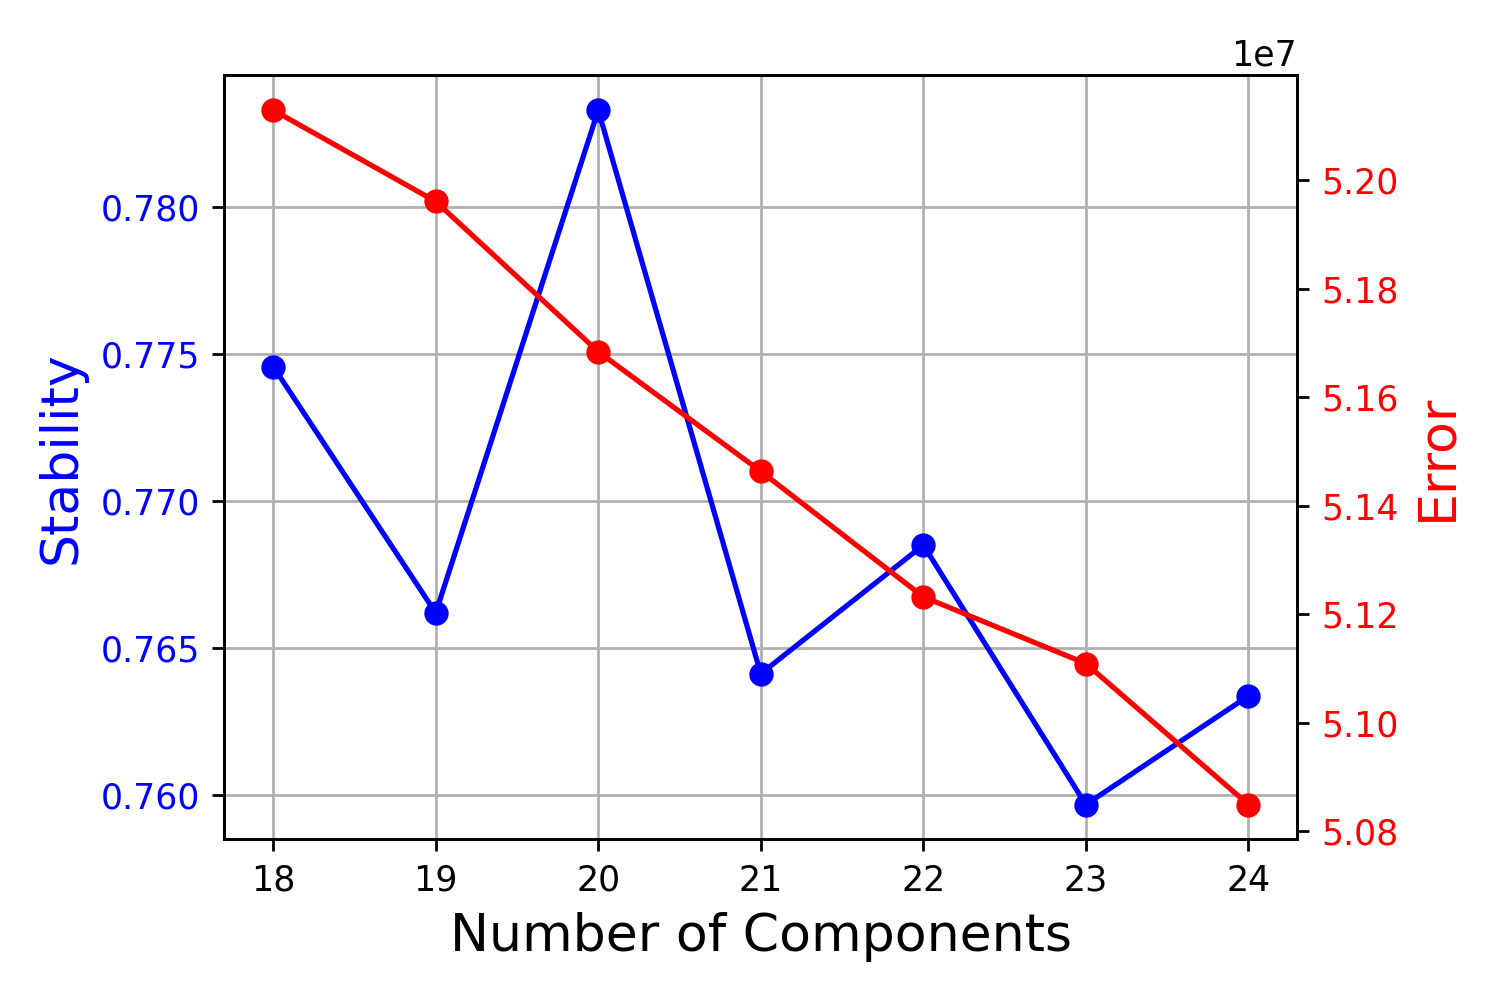

In [8]:
Image(filename = "cNMF/treated_tumor_cNMF/%s/%s.k_selection.png"%(run_name, run_name), width=1000, height=1000)

In [9]:
selected_K = 22
density_threshold = 2.00

In [10]:
## This is the command you would run from the command line to obtain the consensus estimate with no filtering
## and to save a diagnostic plot as a PDF
consensus_cmd = '/home/unix/kjag/.conda/envs/pegasus/bin/python cnmf.py consensus --output-dir %s --name %s --local-density-threshold %.2f --components %d --show-clustering' % (output_directory, run_name, density_threshold, selected_K)
print('Consensus command for K=%d:\n%s' % (selected_K, consensus_cmd))
!{consensus_cmd}

Consensus command for K=22:
/home/unix/kjag/.conda/envs/pegasus/bin/python cnmf.py consensus --output-dir /ahg/regevdata/projects/Pancreas/src/cNMF/treated_tumor_cNMF --name pbmc_cNMF2 --local-density-threshold 2.00 --components 22 --show-clustering
/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/unix/kjag/.conda/envs/pegasus/lib/python3.7/site-packages/numpy/lib/format.py:356: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
cnmf.py:568: RuntimeWarning: invalid value encountered in true_divide
  norm_tpm = (np.array(tpm.X.todense()) - tpm_stats['__mean'].values) / tpm_stats['__std'].values
/home/unix/kjag/.conda/envs/pegasus/lib/py

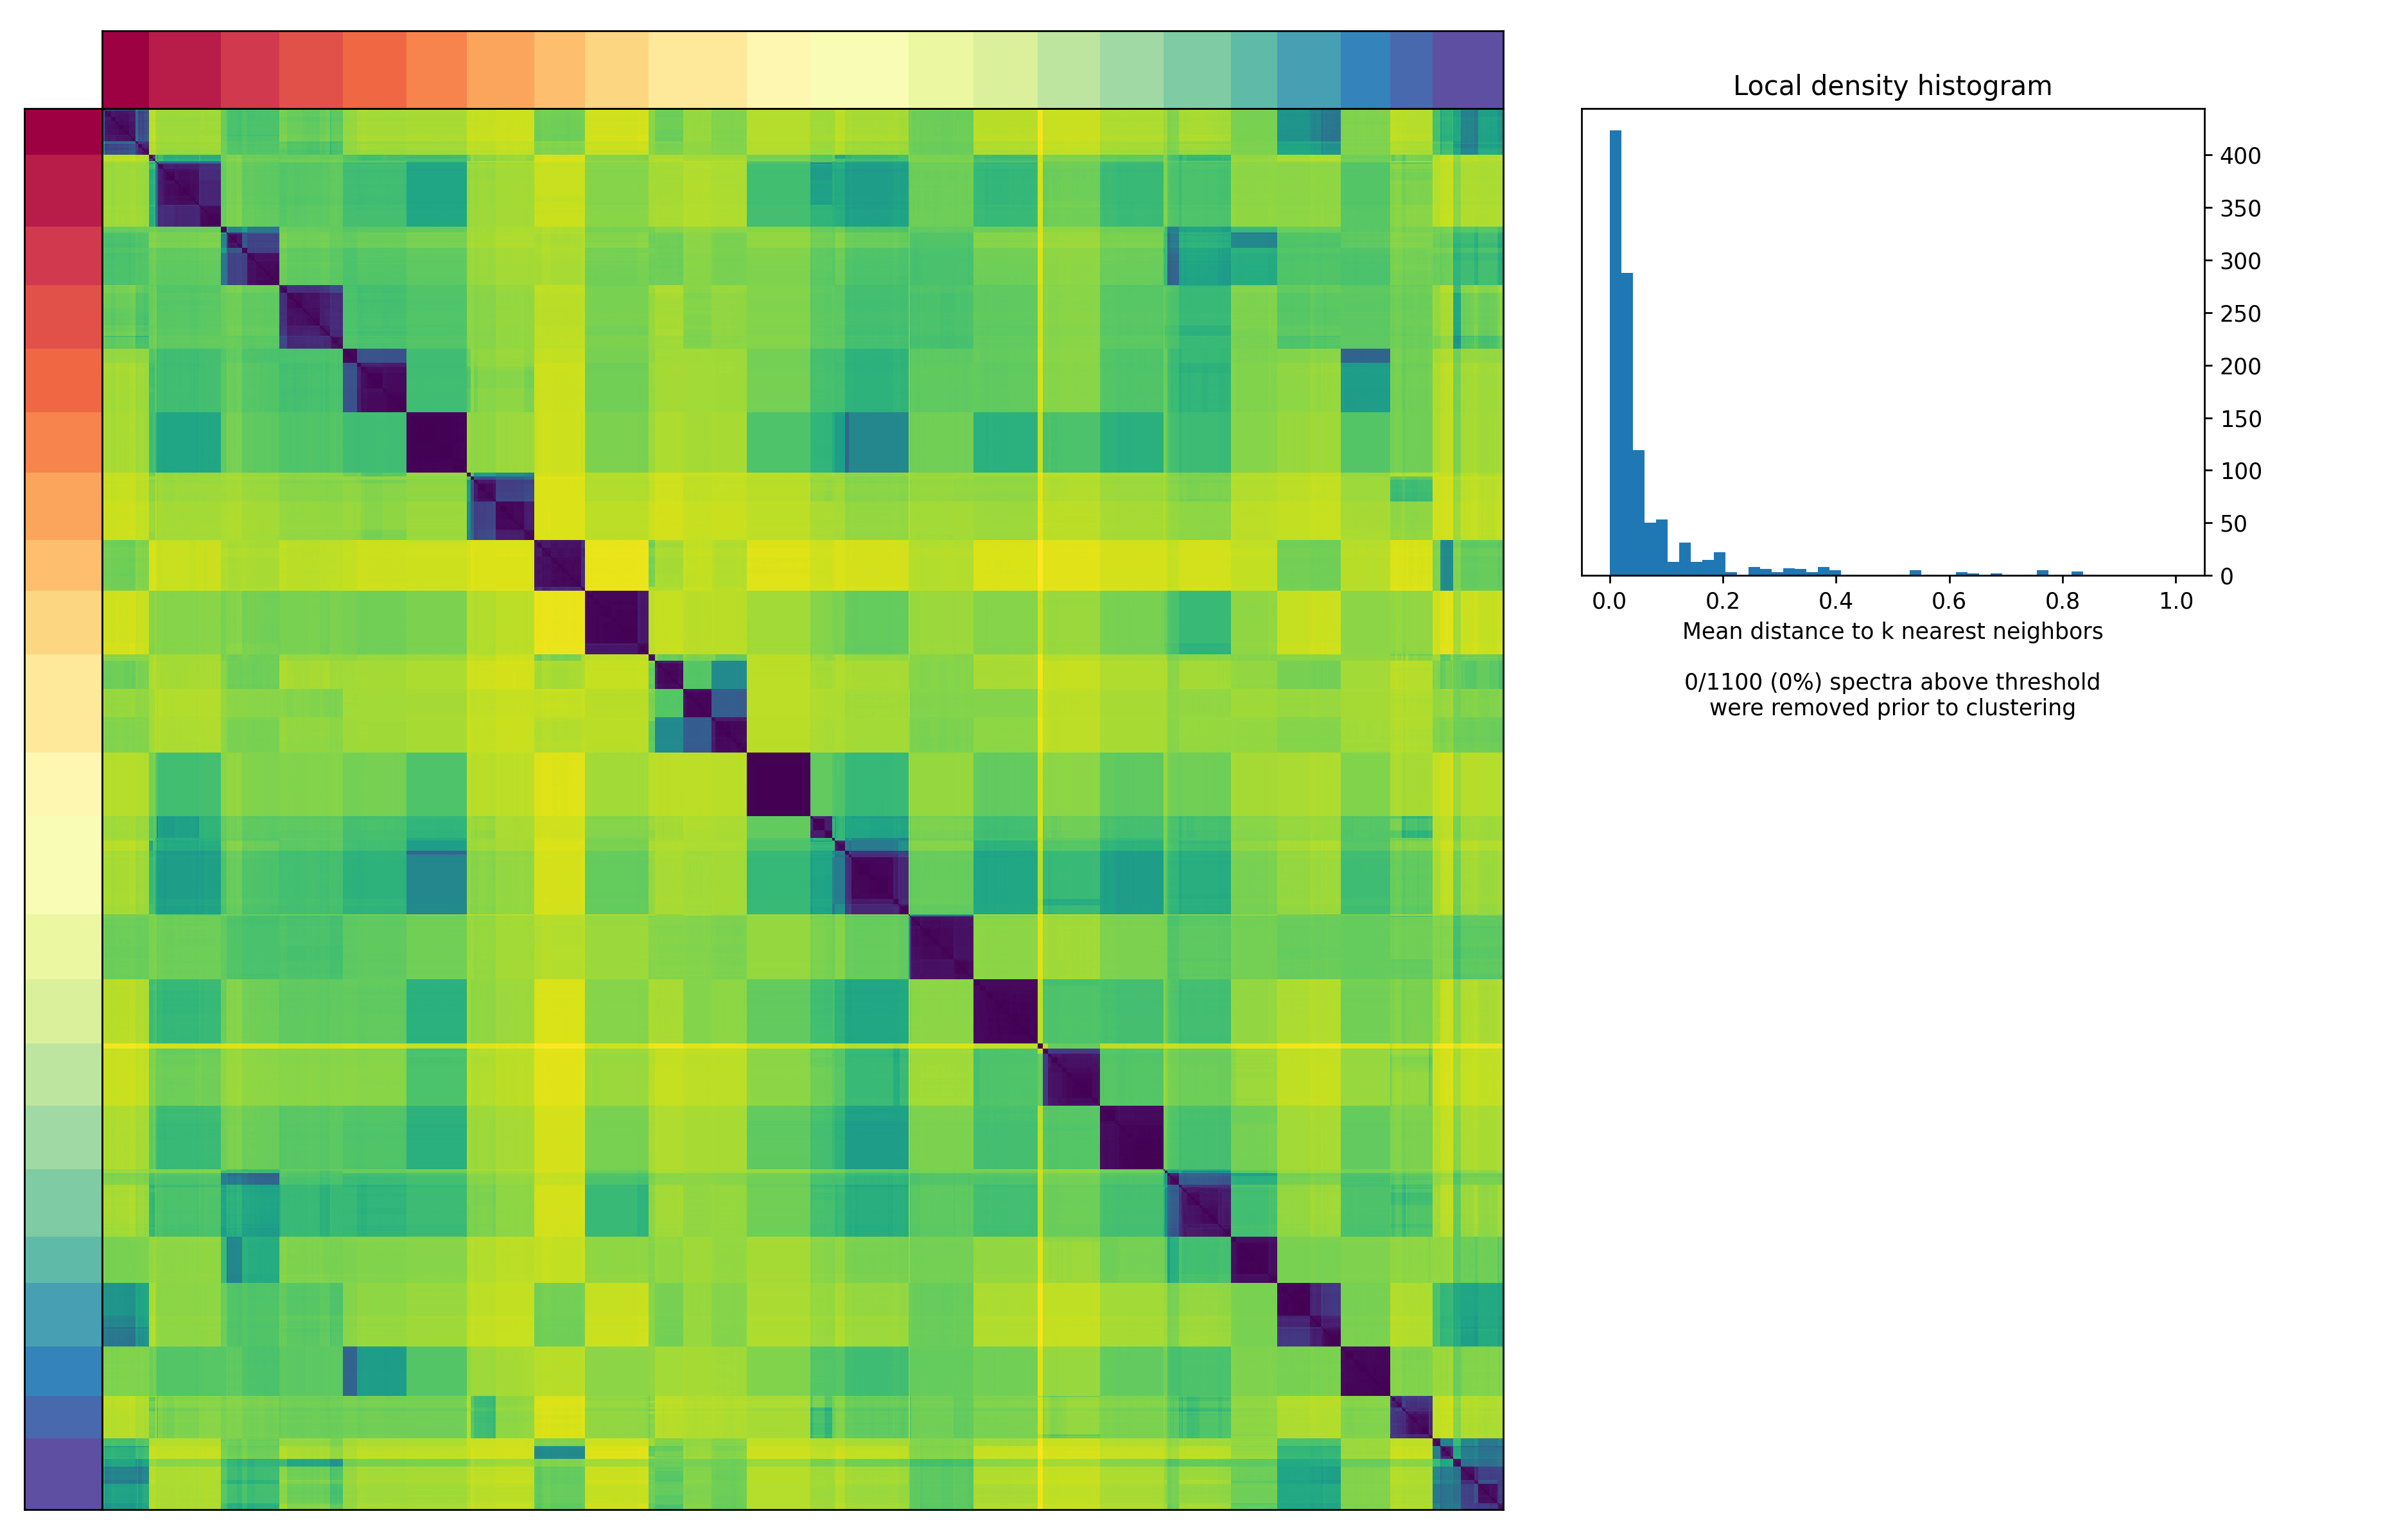

In [11]:
density_threshold_str = ('%.2f' % density_threshold).replace('.', '_')
Image(filename = "cNMF/treated_tumor_cNMF/%s/%s.clustering.k_%d.dt_%s.png" % (run_name, run_name, selected_K, density_threshold_str), width=1000, height=1000)

In [12]:
subsetdata = sc.read('/ahg/regevdata/projects/Pancreas/src/treatedtumor_nmf.h5ad')

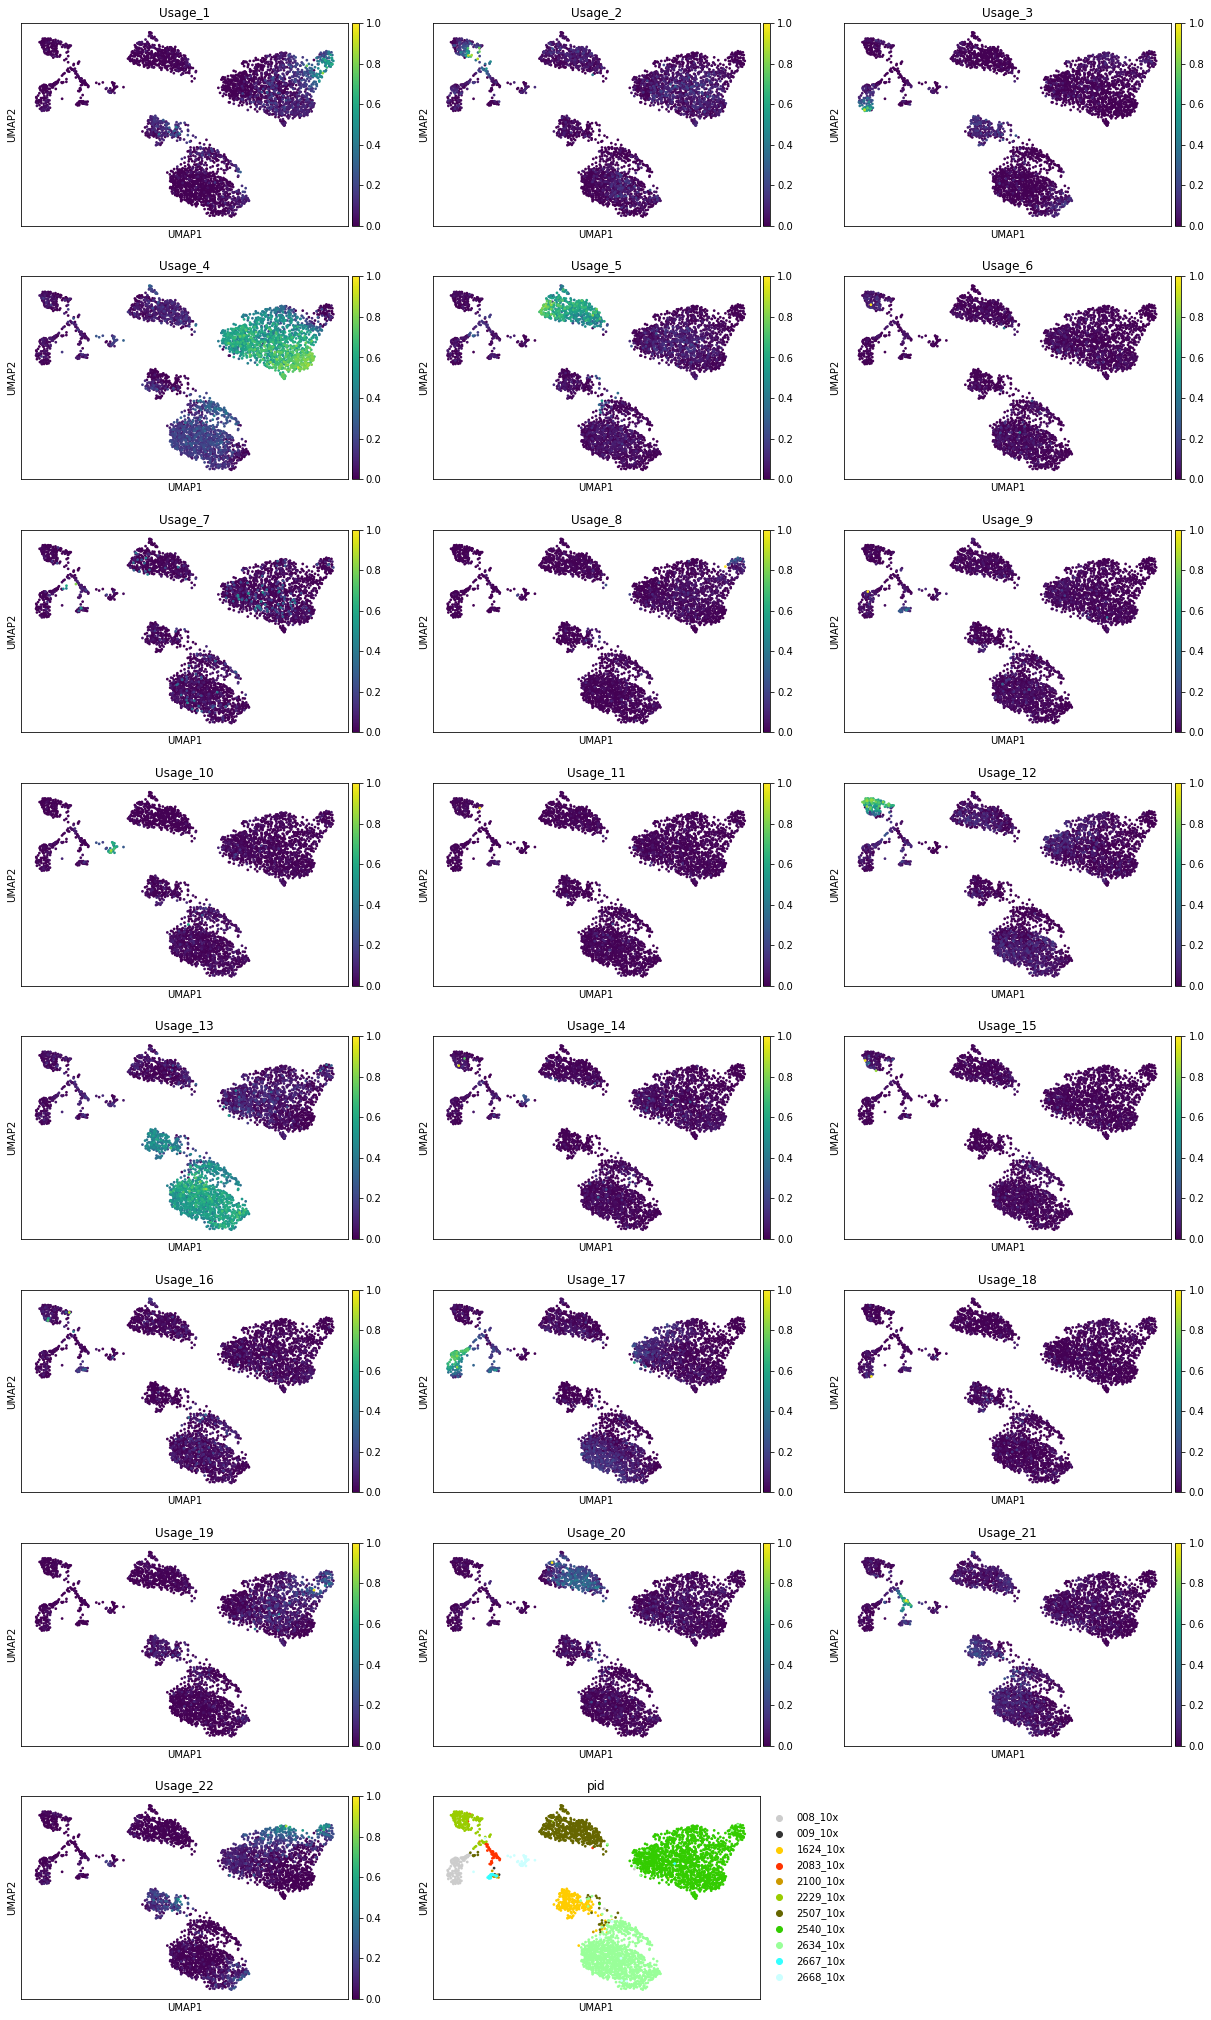

In [13]:
usage = pd.read_csv('./cNMF/treated_tumor_cNMF/%s/%s.usages.k_%d.dt_%s.consensus.txt' % (run_name, run_name, selected_K, density_threshold_str),
                    sep='\t', index_col=0)
usage.columns = ['Usage_%s' % i for i in usage.columns]
usage_norm = usage.div(usage.sum(axis=1), axis=0)
subsetdata.obs = pd.merge(left=subsetdata.obs, right=usage_norm, how='left', left_index=True, right_index=True)
sc.pl.umap(subsetdata, color=list(usage_norm.columns) + ['pid'], ncols=3, vmin=0, vmax=1, save="04242020_treated_tumor_%d.png"%selected_K)

In [14]:
## Load the Z-scored GEPs which reflect how enriched a gene is in each GEP relative to all of the others
gene_scores = pd.read_csv('./cNMF/treated_tumor_cNMF/%s/%s.gene_spectra_score.k_%d.dt_%s.txt' % (run_name, run_name, selected_K, density_threshold_str),
                    sep='\t', index_col=0).T

## Obtain the top 100 genes for each GEP in sorted order and combine them into a single dataframe
top_genes = []
ngenes = 200
for gep in gene_scores.columns:
    top_genes.append(list(gene_scores.sort_values(by=gep, ascending=False).index[:ngenes]))
    
top_genes = pd.DataFrame(top_genes, index=gene_scores.columns).T
top_genes

1           2           3            4          5   \
0            NDUFB8  AC006041.1    TAB3-AS1      ZNF804A      NPSR1   
1    RPL17-C18orf32   TRPC7-AS2   ITIH4-AS1         MMP3    L3MBTL4   
2           C3orf36      ZNF605        G6PC      MSC-AS1     RNF157   
3          MTRNR2L6  AC118345.1        BBS1       PLXDC2    SLC7A11   
4        CACTIN-AS1       SOX18        CLN3         PVT1  LINC00364   
..              ...         ...         ...          ...        ...   
195             BSG        LTV1       PLCD3         CTIF      KANTR   
196            ACTB        MID2      EEF1A1  SLC16A1-AS1      P4HA1   
197            PKP3      CTNNA1        LMO4        TULP4   KIAA1328   
198           HSPB1       ITGA6  AC018742.1        MAGI2     PTPN13   
199           NACA2      TM4SF1  ZNF571-AS1        DECR1       CERK   

              6        7           8           9           10  ...        13  \
0            IL4    ROPN1     DDC-AS1       ASCL4     CFAP206  ...      PLAT   
1        DEFB133     GRM2     FAM163B  SLC9A9-AS1  AC093911.1  ...    TM4SF4   
2          TMOD4  SLC35G6  UBE2E2-AS1  AC112721.1      CYP4B1  ...    LINGO1   
3    ZMYND10-AS1    MS4A1   LINC01449      OR2T10     FAM183A  ...       FOS   
4      LINC01613     ANLN        PRB3     CLEC10A     CCDC178  ...     MUC13   
..           ...      ...         ...         ...         ...  ...       ...   
195         CAP2    UBE2T      LRRC49       VENTX     ANKDD1B  ...   DSCAML1   
196    LINC00384    RFWD3        H1FX       IGSF6        DRC1  ...     TAPBP   
197        NDST2  SERINC4       RPL14         CPQ   LINC01513  ...  ARHGEF38   
198        PATE3   OTUD7A     CD200R1        WNK2       NR0B2  ...    EPS8L1   
199      RHOBTB3     PRC1  GADD45GIP1      SLC1A1       DNPH1  ...    KDELR1   

            14          15           16          17         18          19  \
0    LINC00567  AC073072.1         GNG3      MYBPC1      HOXB1  AP001189.4   
1         ZBBX   LINC01213     RORB-AS1       TDRD1  FGF12-AS3        PDXP   
2       RSPH4A  CACTIN-AS1   AC007731.1      SEMA6D     PABPC5       CD79A   
3        ARMC3     TMEM252  FPGT-TNNI3K  AC074033.1     CYP4F2       KRT34   
4        DNAH6   LINC01151   AC006019.3  AP000221.1       PRH2     C3orf36   
..         ...         ...          ...         ...        ...         ...   
195    CCDC151        CSF1        HTR1F      ACTR3C   ST20-AS1       ZBED2   
196        UTY       METRN      HRASLS2     SLC35D1       CBR1      SEC61B   
197    ST8SIA1       WDR27       FIP1L1      RAVER2      CMPK1     PRELID1   
198      IFFO2     FAM120C        GSTA3       CALCB      MSMO1   HOXA10-AS   
199     TMEM67      ACTR3B    KIAA1324L       STOX2      TINAG      NDUFB4   

           20          21       22  
0    C15orf59   LAMP5-AS1     LY75  
1      ELOVL3      AMIGO3   SLC51B  
2        GRM2         GP2  SOSTDC1  
3     SLC10A4        CPA1    CSAG1  
4      OR10T2    PNLIPRP1  RARRES3  
..        ...         ...      ...  
195    PLXNA3       PDIA2     AGR2  
196     DNMBP       KDM4C    GGACT  
197    FUNDC2     COL28A1   TAGLN2  
198     CRIM1      CARD10    PRDX5  
199     CHAC1  AC019117.1     RPSA  

[200 rows x 22 columns]

In [15]:
top_genes.T.to_csv('/ahg/regevdata/projects/Pancreas/src/cNMF/treated_tumor_cNMF/20200503_treatedtumor_topics.%d.txt'%selected_K)

In [16]:
subsetdata.obsm['usage_nmf%d'%selected_K] = usage.values
subsetdata.varm['genescores_nmf%d'%selected_K] = gene_scores.values

In [17]:
subsetdata.write('/ahg/regevdata/projects/Pancreas/src/cNMF/treated_tumor_cNMF/treatedtumorNMF.h5ad')